# Robyn Budget Allocator Demo

This notebook demonstrates how to use the Python implementation of Robyn's budget allocator.
It shows how to:
1. Load and prepare data
2. Configure the allocator
3. Run optimization scenarios
4. Analyze and visualize results

## Step 1: Load Exported R Data

In [1]:
import sys
import pandas as pd
import numpy as np
from typing import Dict, Any

# Add Robyn to path
sys.path.append("/Users/yijuilee/robynpy_release_reviews/Robyn/python/src")

# Import necessary Robyn classes
from robyn.data.entities.mmmdata import MMMData
from robyn.modeling.entities.modeloutputs import ModelOutputs
from robyn.data.entities.hyperparameters import Hyperparameters
from robyn.allocator.entities.enums import OptimizationScenario, ConstrMode
from robyn.allocator.budget_allocator import BudgetAllocator
from robyn.modeling.pareto.pareto_optimizer import ParetoResult
from robyn.allocator.entities.allocation_config import AllocationConfig
from robyn.allocator.entities.allocation_constraints import AllocationConstraints
from utils.data_mapper import load_data_from_json, import_input_collect, import_output_collect, import_output_models

/Users/yijuilee/robynpy_release_reviews/robynvenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load data from JSON exported from R
raw_input_collect = load_data_from_json(
    "/Users/yijuilee/robynpy_release_reviews/Robyn/python/src/tutorials/data/Allocator_InputCollect.json"
)
raw_output_collect = load_data_from_json(
    "/Users/yijuilee/robynpy_release_reviews/Robyn/python/src/tutorials/data/Allocator_OutputCollect.json"
)
raw_output_models = load_data_from_json(
    "/Users/yijuilee/robynpy_release_reviews/Robyn/python/src/tutorials/data/Allocator_OutputModels.json"
)

# Convert R data to Python objects
r_input_collect = import_input_collect(raw_input_collect)
r_output_collect = import_output_collect(raw_output_collect)
python_model_outputs = import_output_models(raw_output_models)

# Extract individual components
mmm_data = r_input_collect["mmm_data"]
featurized_mmm_data = r_input_collect["featurized_mmm_data"]
holidays_data = r_input_collect["holidays_data"]
model_outputs = python_model_outputs
hyperparameters = r_input_collect["hyperparameters"]

# Print data summary
print(f"Data loaded successfully:")
print(
    f"- Data timeframe: {mmm_data.data[mmm_data.mmmdata_spec.date_var].min()} to {mmm_data.data[mmm_data.mmmdata_spec.date_var].max()}"
)
print(f"- Number of paid media channels: {len(mmm_data.mmmdata_spec.paid_media_spends)}")
print(f"- Channels: {mmm_data.mmmdata_spec.paid_media_spends}")

Data loaded successfully:
- Data timeframe: DATE    2015-11-23
dtype: object to DATE    2019-11-11
dtype: object
- Number of paid media channels: 5
- Channels: ['tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S']


## Step 2: Set up Budget Allocator

Initialize the budget allocator with the selected model and data.

In [3]:
# # Print some debugging information
# print(f"Model ID: {select_model}")
# print("\nAvailable models in result_hyp_param:")
# print(r_output_collect["pareto_result"].result_hyp_param["solID"].unique())
# print("\nColumns in result_hyp_param:")
# print(r_output_collect["pareto_result"].result_hyp_param.columns)

In [4]:
# Debug date data
print("\nDate column info:")
# Ensure the column name is correctly accessed and is a string
# If it's a list, extract the first element
if isinstance(mmm_data.mmmdata_spec.date_var, list):
    column_name = mmm_data.mmmdata_spec.date_var[0]
else:
    column_name = mmm_data.mmmdata_spec.date_var
print(column_name)
# Check if the column exists in the DataFrame
if column_name in mmm_data.data.columns:
    print(f"Column name: {column_name}")
    print(f"Data type: {mmm_data.data[column_name].dtype}")
    print("\nFirst few dates:")
    print(mmm_data.data[column_name].head())
else:
    print(f"Column '{column_name}' does not exist in the DataFrame.")


Date column info:
DATE
Column name: DATE
Data type: object

First few dates:
0    2015-11-23
1    2015-11-30
2    2015-12-07
3    2015-12-14
4    2015-12-21
Name: DATE, dtype: object


In [5]:
display(mmm_data.data.head())

,DATE,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter
0,2015-11-23,2.754372e+06,22358.3467,0.0,12728.4889,2.430128e+07,0.0000,0.0000,8125009,7607.1329,na,19401.6538
1,2015-11-30,2.584277e+06,28613.4533,0.0,0.0000,5.527033e+06,9837.2385,4133.3333,7901549,1141.9525,na,14791.0000
2,2015-12-07,2.547387e+06,0.0000,132278.4,453.8667,1.665159e+07,12044.1197,3786.6667,8300197,4256.3754,na,14544.0000
3,2015-12-14,2.875220e+06,83450.3067,0.0,17680.0000,1.054977e+07,12268.0703,4253.3333,8122883,2800.4907,na,2800.0000
4,2015-12-21,2.215953e+06,0.0000,277336.0,0.0000,2.934090e+06,9467.2480,3613.3333,7105985,689.5826,na,15478.0000


In [6]:
# Select model ID from available solutions
select_model = "1_208_4"  # This should match one of your model IDs

# Initialize budget allocator
allocator = BudgetAllocator(
    mmm_data=mmm_data,
    featurized_mmm_data=featurized_mmm_data,
    model_outputs=model_outputs,
    pareto_result=r_output_collect["pareto_result"],  # Get ParetoResult from import_output_collect()
    select_model=select_model,
)

## Step 3: Configure Allocation Settings

Set up constraints and parameters for optimization.

In [7]:
# Create channel constraints
channel_constraints = AllocationConstraints(
    channel_constr_low={channel: 0.7 for channel in mmm_data.mmmdata_spec.paid_media_spends},
    channel_constr_up={channel: 1.2 for channel in mmm_data.mmmdata_spec.paid_media_spends},
    channel_constr_multiplier=3.0,
)

# Create allocation configuration for max response scenario
max_response_config = AllocationConfig(
    scenario=OptimizationScenario.MAX_RESPONSE,
    constraints=channel_constraints,
    date_range="last",  # Use last period as initial
    total_budget=None,  # Use historical budget
    maxeval=100000,
    optim_algo="SLSQP_AUGLAG",
    constr_mode=ConstrMode.EQUALITY,
    plots=True,
)

## Step 4: Run Optimization Scenarios

### Scenario 1: Maximize Response
Find optimal allocation to maximize response while keeping total budget constant.

In [8]:
# Run max response optimization
max_response_result = allocator.allocate(max_response_config)

# Print optimization results
print("\nMax Response Optimization Results:")
print(max_response_result.summary)

# Display optimal allocations
print("\nOptimal Channel Allocations:")
print(max_response_result.optimal_allocations)


Max Response Optimization Results:

        Optimization Results Summary:
        Total Spend: $12,206.36
        Expected Response Lift: 0.0%
        Channels Optimized: 5
        
        

Optimal Channel Allocations:
               channel  current_spend  optimal_spend  current_response  \
tv_S              tv_S         0.0000         0.0000          0.000000   
ooh_S            ooh_S         0.0000         0.0000          0.000000   
print_S        print_S         0.0000         0.0000          0.000000   
facebook_S  facebook_S     12206.3586     12206.3586      15617.461824   
search_S      search_S         0.0000         0.0000          0.000000   

            optimal_response  
tv_S                0.000000  
ooh_S               0.000000  
print_S             0.000000  
facebook_S      15617.461824  
search_S            0.000000  


/Users/yijuilee/robynpy_release_reviews/Robyn/python/src/robyn/allocator/response_calculator.py:28: RuntimeWarning: divide by zero encountered in scalar divide
  x_out = coef * np.sum((1 + inflexion**alpha / x_adstocked**alpha) ** -1)
/Users/yijuilee/robynpy_release_reviews/Robyn/python/src/robyn/allocator/response_calculator.py:44: RuntimeWarning: divide by zero encountered in scalar power
  (alpha * (inflexion**alpha) * (x_adstocked ** (alpha - 1))) / (x_adstocked**alpha + inflexion**alpha) ** 2
/Users/yijuilee/robynpy_release_reviews/Robyn/python/src/robyn/allocator/budget_allocator.py:453: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_spend = max(optimal_spend[i], current_spend[i]) * 1.5
/Users/yijuilee/robynpy_release_reviews/robynvenv/lib/python3.9/site-packages/numpy/lib/_function_base_impl

### Scenario 2: Target Efficiency
Optimize allocation based on target ROI/CPA.

In [9]:
# Create configuration for target efficiency scenario
target_efficiency_config = AllocationConfig(
    scenario=OptimizationScenario.TARGET_EFFICIENCY,
    constraints=channel_constraints,
    date_range="last",
    target_value=None,  # Will use default 80% of initial ROAS or 120% of initial CPA
    maxeval=100000,
    optim_algo="SLSQP_AUGLAG",
    constr_mode=ConstrMode.EQUALITY,
    plots=True,
)

# Run target efficiency optimization
target_efficiency_result = allocator.allocate(target_efficiency_config)

# Print optimization results
print("\nTarget Efficiency Optimization Results:")
print(target_efficiency_result.summary)

# Display optimal allocations
print("\nOptimal Channel Allocations:")
print(target_efficiency_result.optimal_allocations)


Target Efficiency Optimization Results:

        Optimization Results Summary:
        Total Spend: $14,647.63
        Expected Response Lift: 7.1%
        Channels Optimized: 5
        
        Target Efficiency: 1.02
        Achieved Efficiency: 1.14
        
        

Optimal Channel Allocations:
               channel  current_spend  optimal_spend  current_response  \
tv_S              tv_S         0.0000        0.00000          0.000000   
ooh_S            ooh_S         0.0000        0.00000          0.000000   
print_S        print_S         0.0000        0.00000          0.000000   
facebook_S  facebook_S     12206.3586    14647.63032      15617.461824   
search_S      search_S         0.0000        0.00000          0.000000   

            optimal_response  
tv_S                0.000000  
ooh_S               0.000000  
print_S             0.000000  
facebook_S      16721.310876  
search_S            0.000000  


/Users/yijuilee/robynpy_release_reviews/Robyn/python/src/robyn/allocator/response_calculator.py:28: RuntimeWarning: divide by zero encountered in scalar divide
  x_out = coef * np.sum((1 + inflexion**alpha / x_adstocked**alpha) ** -1)
/Users/yijuilee/robynpy_release_reviews/Robyn/python/src/robyn/allocator/response_calculator.py:44: RuntimeWarning: divide by zero encountered in scalar power
  (alpha * (inflexion**alpha) * (x_adstocked ** (alpha - 1))) / (x_adstocked**alpha + inflexion**alpha) ** 2
/Users/yijuilee/robynpy_release_reviews/Robyn/python/src/robyn/allocator/budget_allocator.py:453: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_spend = max(optimal_spend[i], current_spend[i]) * 1.5
/Users/yijuilee/robynpy_release_reviews/robynvenv/lib/python3.9/site-packages/numpy/lib/_function_base_impl

## Step 5: Analyze Results

Compare and analyze the results from different scenarios.

In [10]:
def compare_scenarios(max_response_result, target_efficiency_result):
    """Compare results from different optimization scenarios."""

    comparison = pd.DataFrame(
        {
            "Max Response": max_response_result.optimal_allocations["optimal_spend"],
            "Target Efficiency": target_efficiency_result.optimal_allocations["optimal_spend"],
        }
    )

    comparison["Difference"] = comparison["Max Response"] - comparison["Target Efficiency"]
    comparison["Difference %"] = (comparison["Difference"] / comparison["Max Response"]) * 100

    return comparison


# Generate comparison
scenario_comparison = compare_scenarios(max_response_result, target_efficiency_result)
print("\nScenario Comparison:")
print(scenario_comparison)


Scenario Comparison:
            Max Response  Target Efficiency  Difference  Difference %
tv_S              0.0000            0.00000     0.00000           NaN
ooh_S             0.0000            0.00000     0.00000           NaN
print_S           0.0000            0.00000     0.00000           NaN
facebook_S    12206.3586        14647.63032 -2441.27172         -20.0
search_S          0.0000            0.00000     0.00000           NaN


## Step 6: Visualize Results

Plot the optimization results and response curves.

/Users/yijuilee/robynpy_release_reviews/Robyn/python/src/robyn/visualization/allocator_visualizer.py:164: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df["channel"], rotation=45, ha="right")
/Users/yijuilee/robynpy_release_reviews/Robyn/python/src/robyn/visualization/allocator_visualizer.py:172: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(df["channel"], rotation=45, ha="right")
/Users/yijuilee/robynpy_release_reviews/Robyn/python/src/robyn/visualization/allocator_visualizer.py:164: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df["channel"], rotation=45, ha="right")
/Users/yijuilee/robynpy_release_reviews/Robyn/python/src/robyn/visualization/allocator_visualizer.py:172: UserWa


Max Response - spend_share:


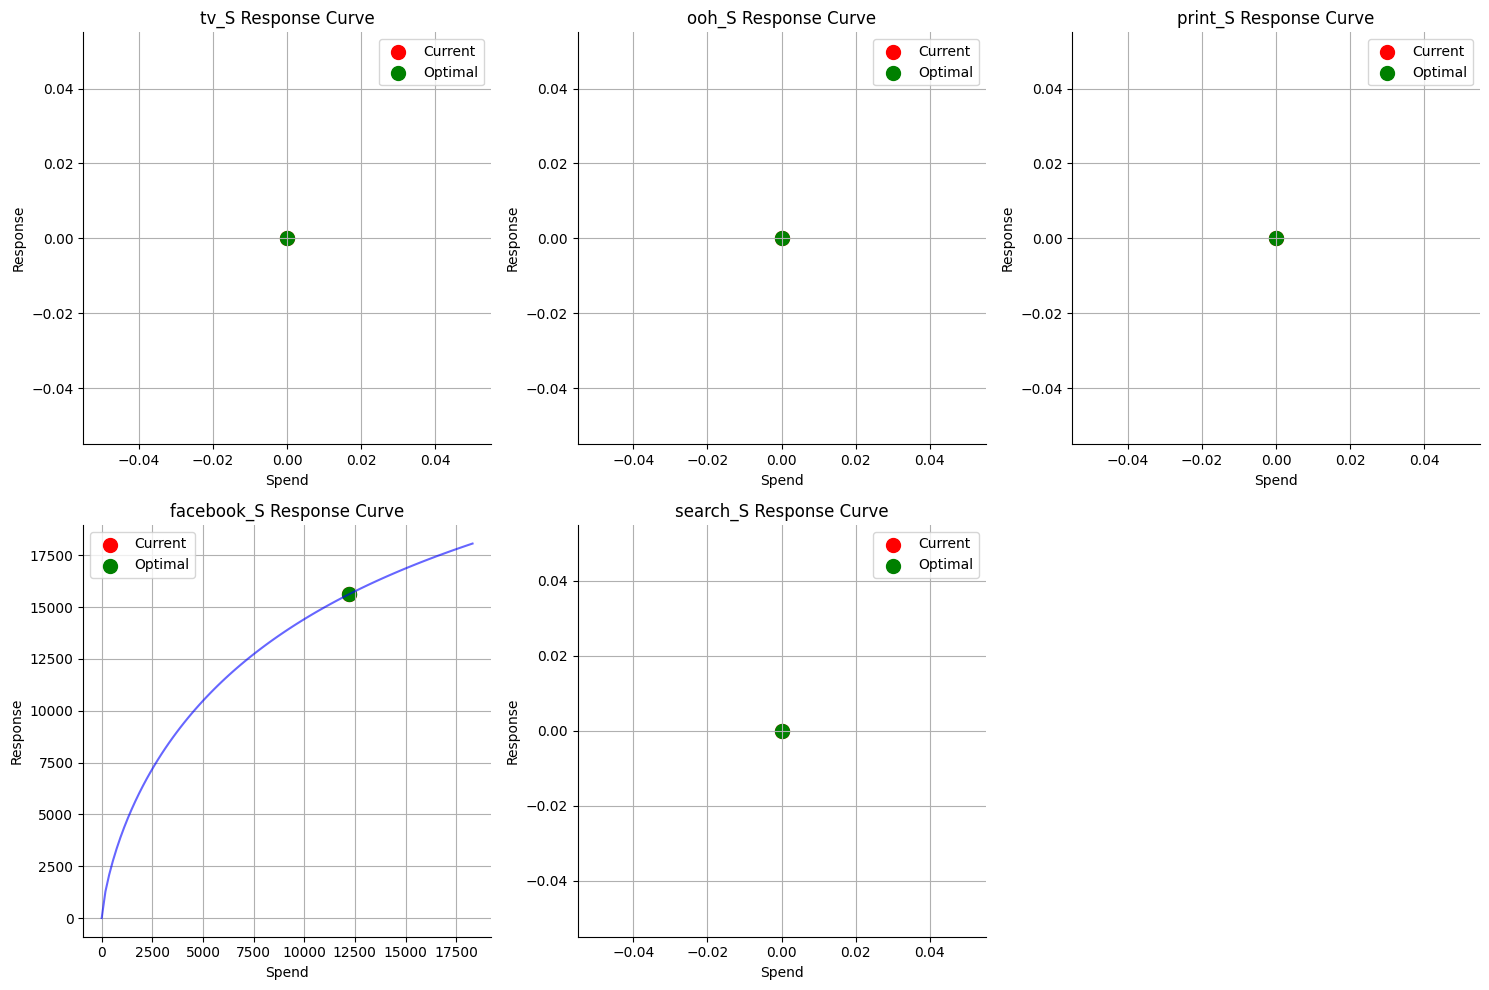

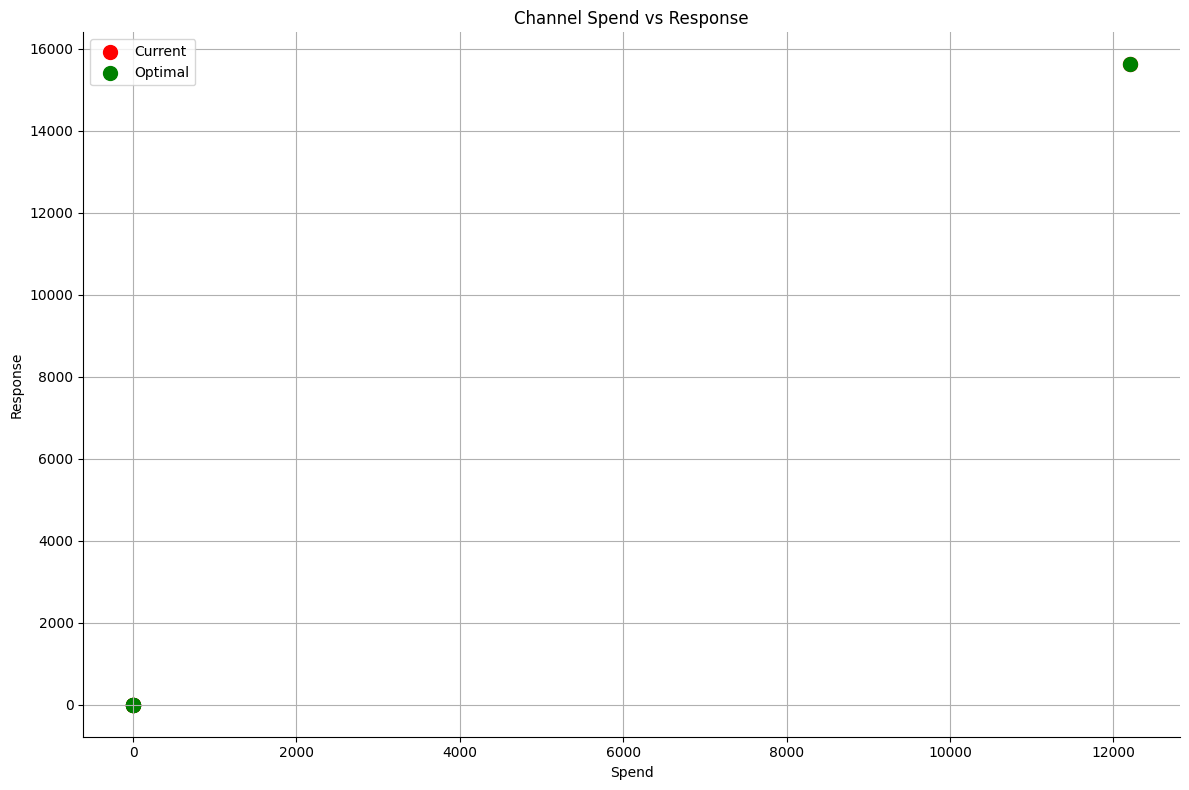

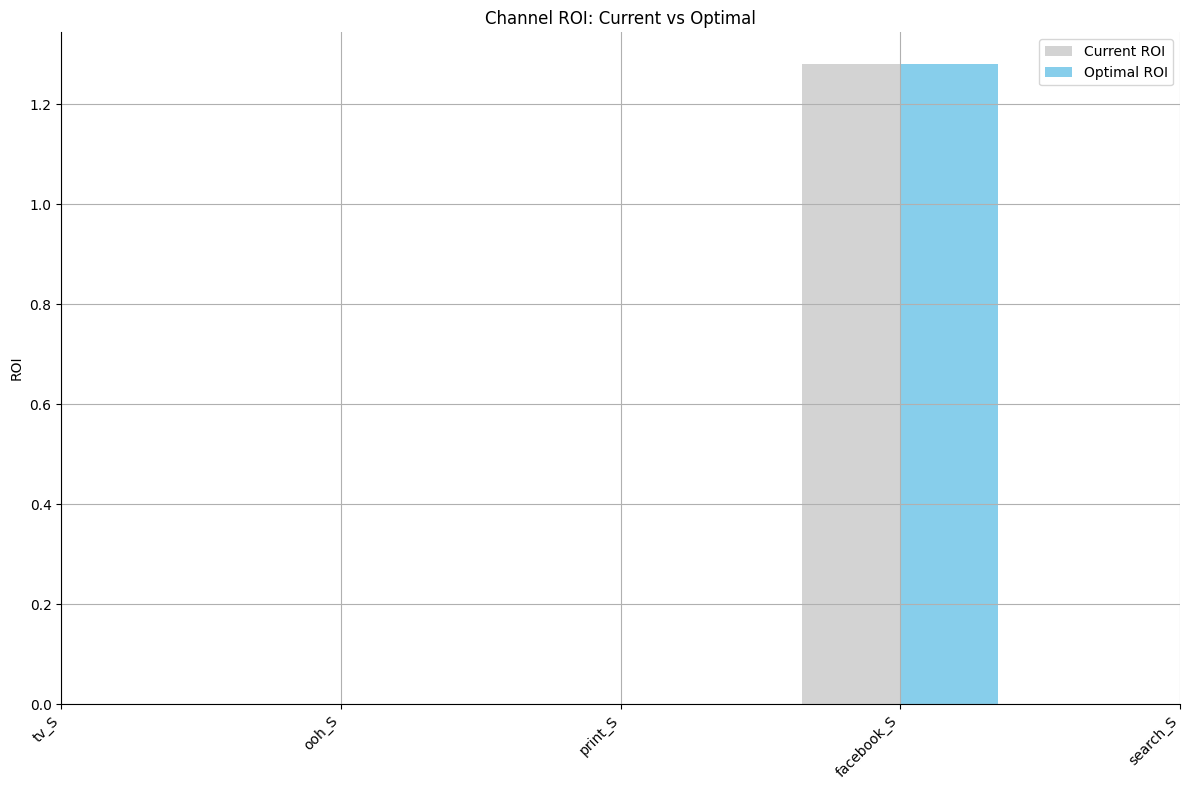

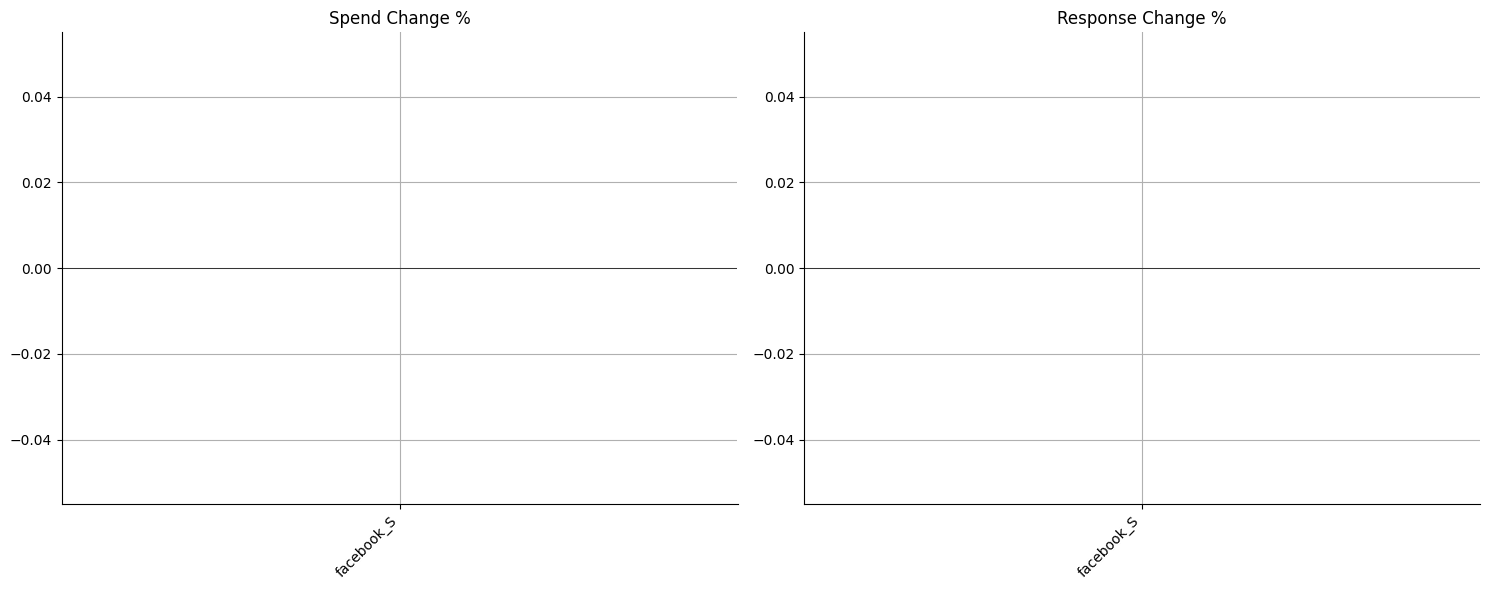

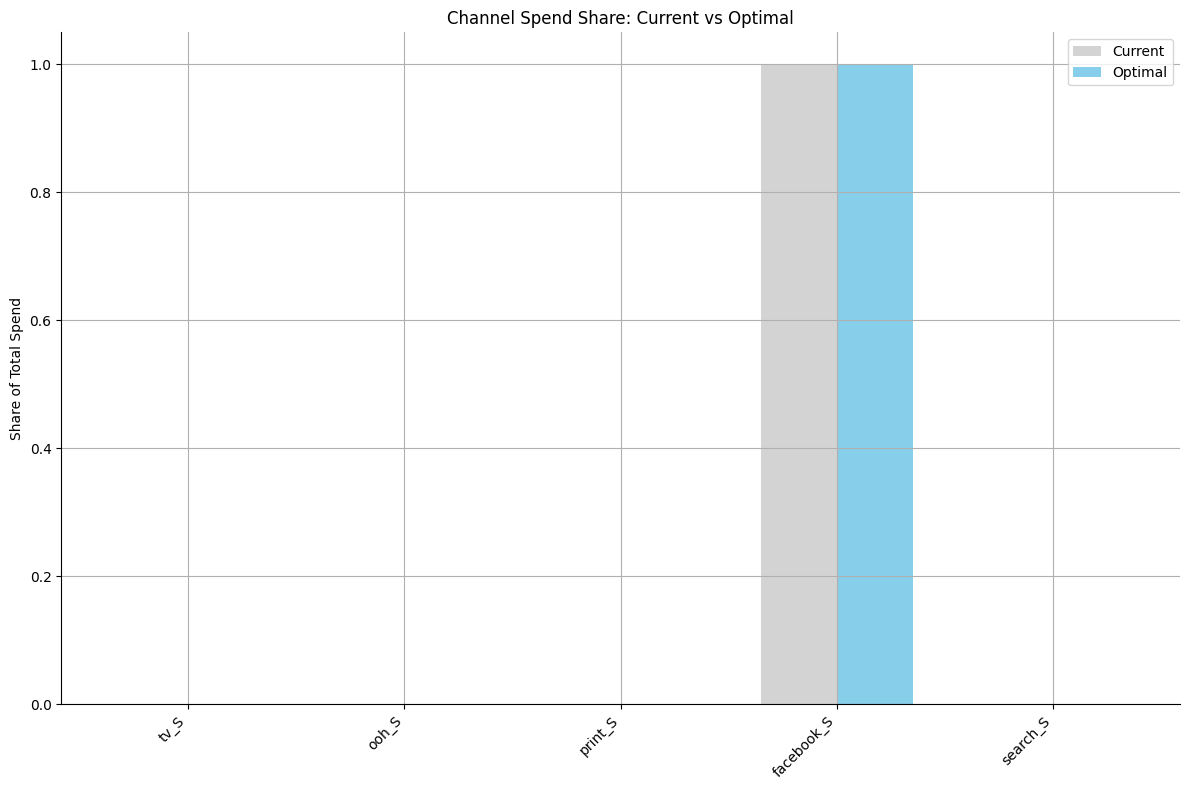

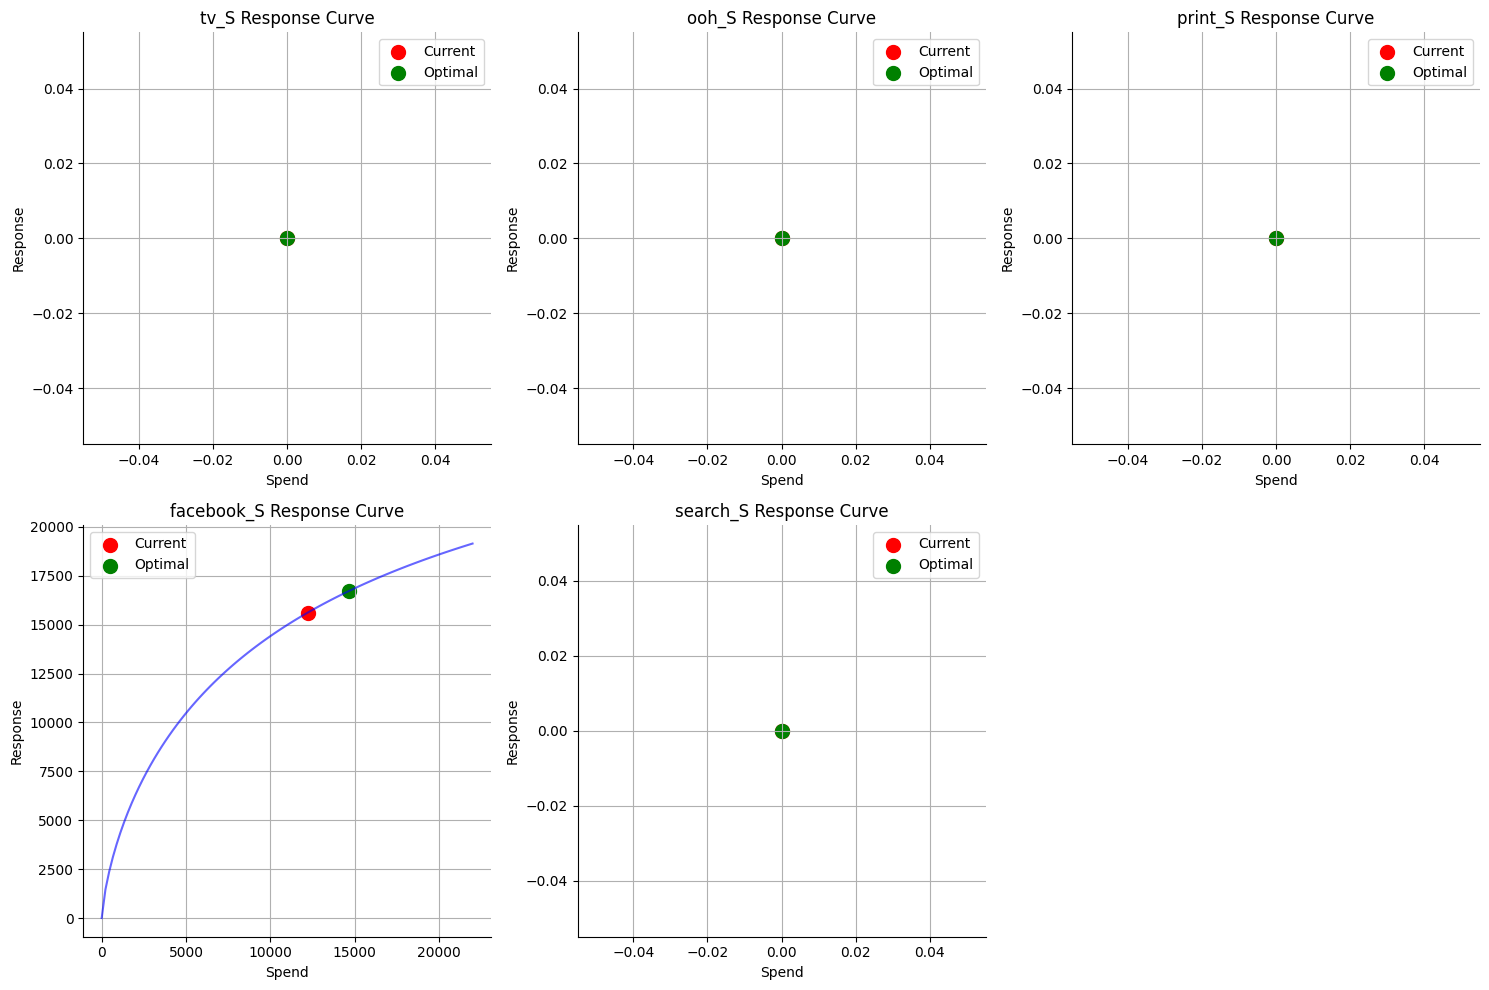

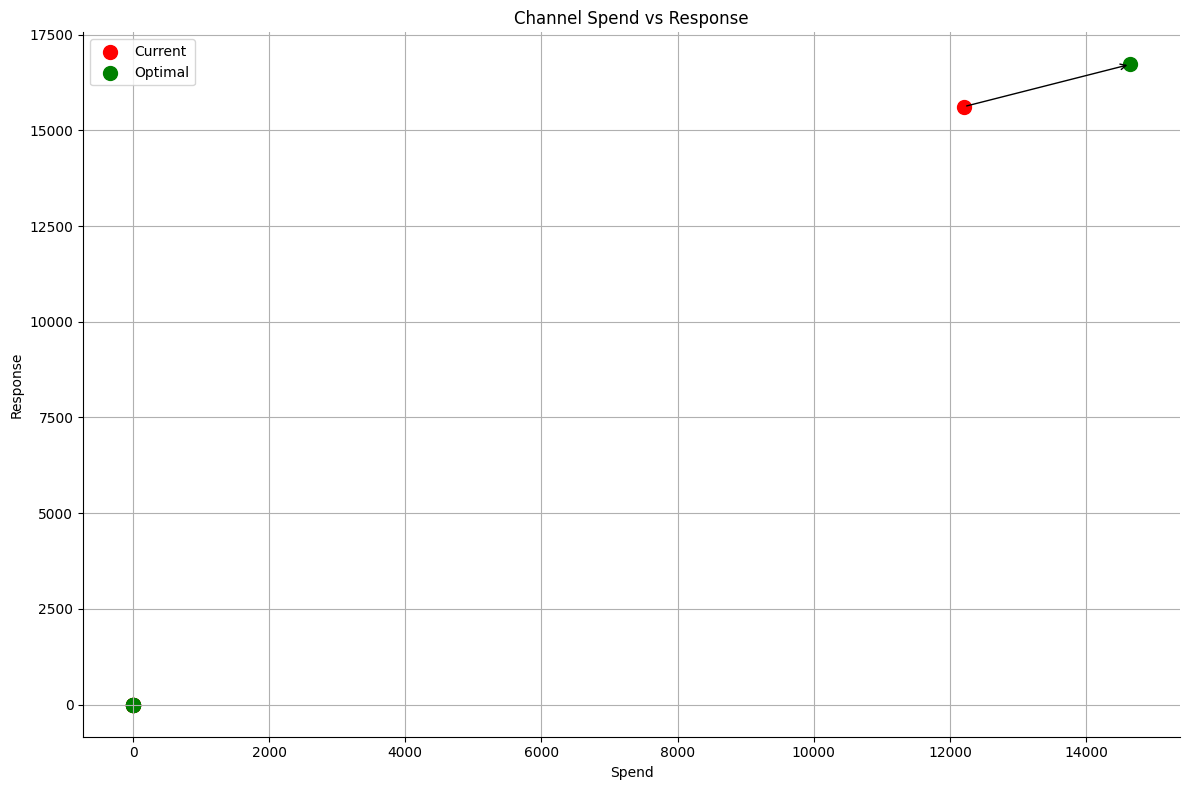

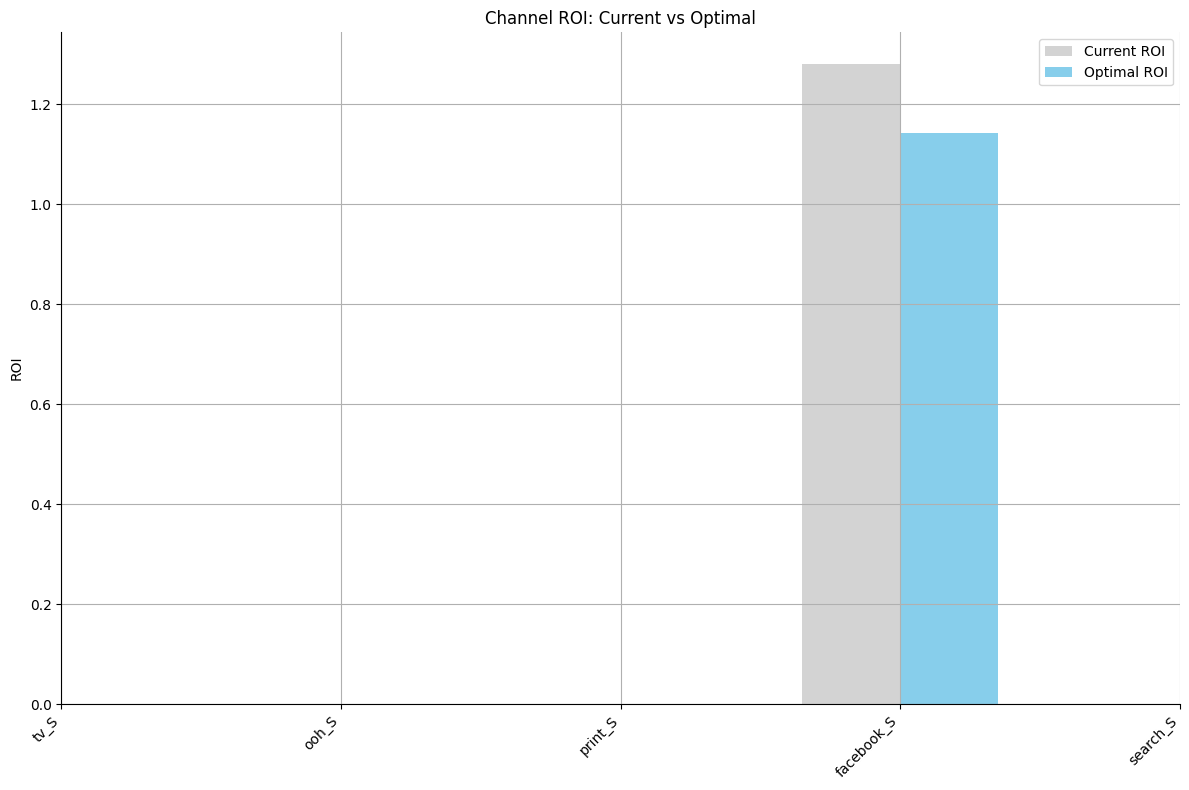

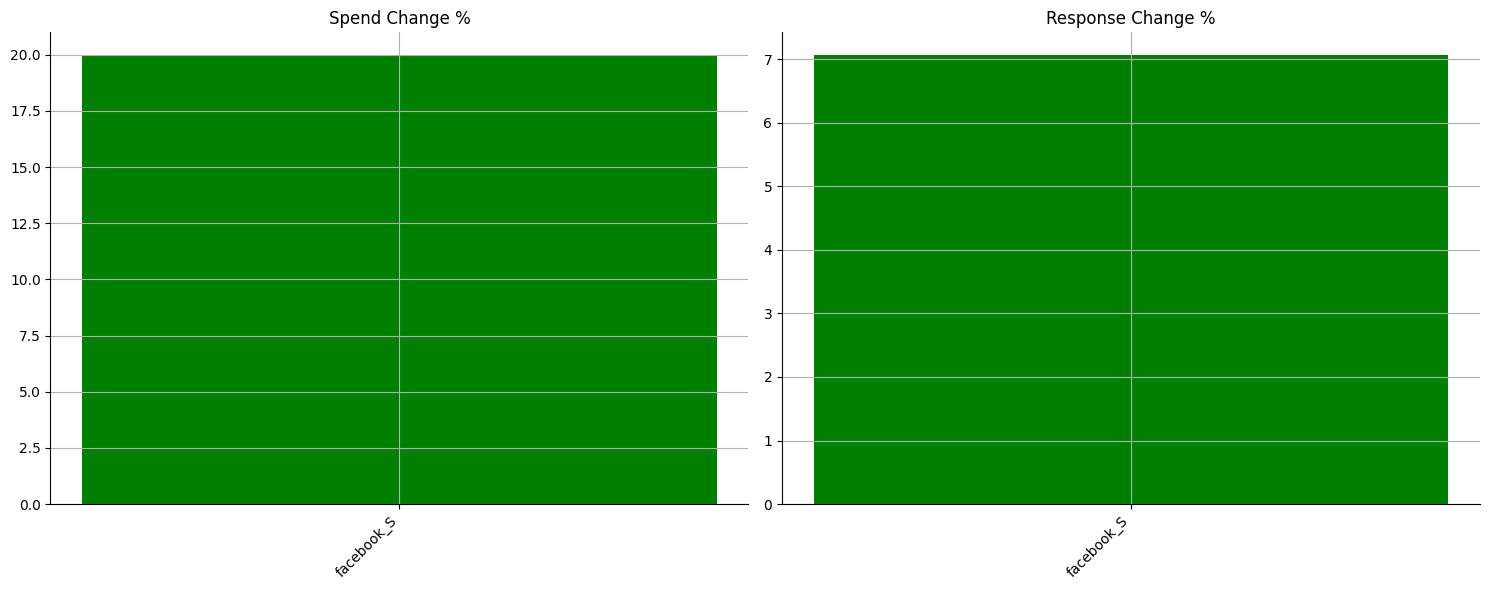

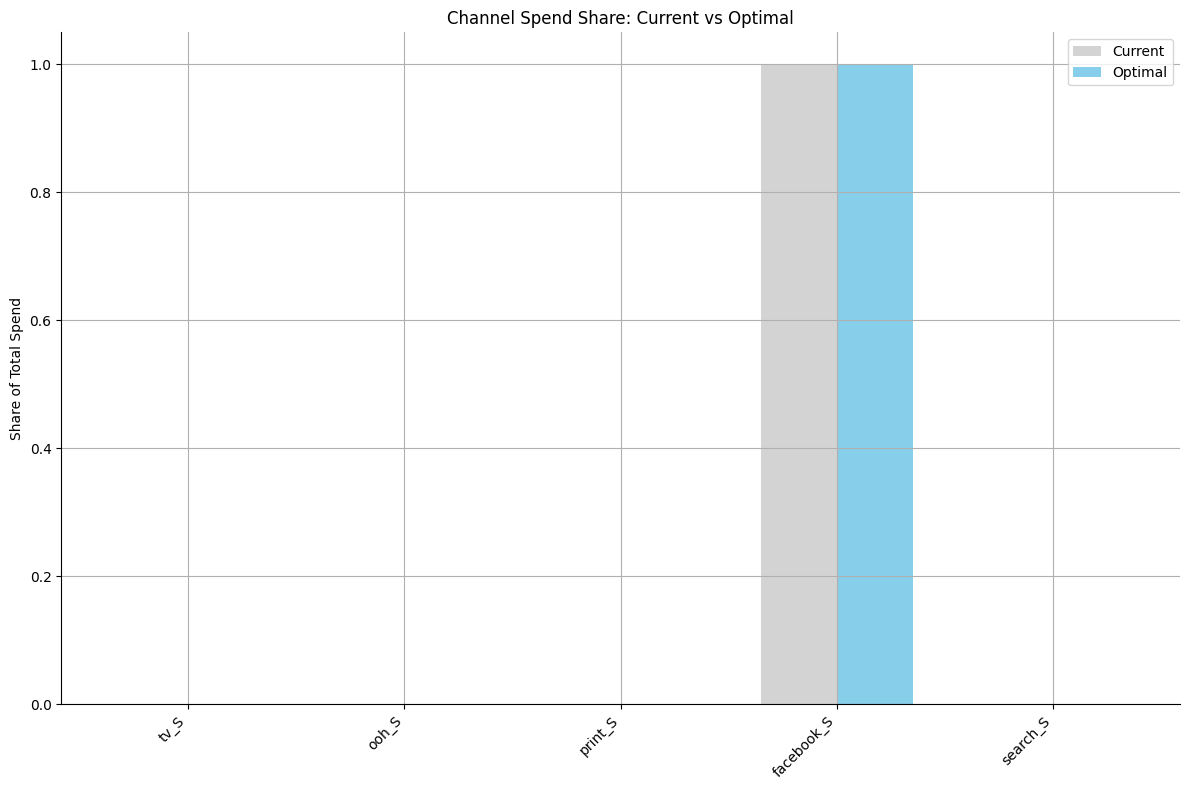


Max Response - response_curves:


<Figure size 1200x800 with 0 Axes>


Max Response - spend_response_scatter:


<Figure size 1200x800 with 0 Axes>


Max Response - roi_comparison:


<Figure size 1200x800 with 0 Axes>


Max Response - spend_response_bars:


<Figure size 1200x800 with 0 Axes>


Target Efficiency - spend_share:


<Figure size 1200x800 with 0 Axes>


Target Efficiency - response_curves:


<Figure size 1200x800 with 0 Axes>


Target Efficiency - spend_response_scatter:


<Figure size 1200x800 with 0 Axes>


Target Efficiency - roi_comparison:


<Figure size 1200x800 with 0 Axes>


Target Efficiency - spend_response_bars:


<Figure size 1200x800 with 0 Axes>

In [12]:
from robyn.visualization.allocator_visualizer import AllocationPlotter
from matplotlib import pyplot as plt
import os

# Create visualization
plotter = AllocationPlotter()

# Generate plots for max response scenario
max_response_plots = plotter.plot_all(max_response_result)

# Generate plots for target efficiency scenario
target_efficiency_plots = plotter.plot_all(target_efficiency_result)

# Display plots
for plot_name, fig in max_response_plots.items():
    plt.figure(fig.number)
    print(f"\nMax Response - {plot_name}:")
    plt.show()

for plot_name, fig in target_efficiency_plots.items():
    plt.figure(fig.number)
    print(f"\nTarget Efficiency - {plot_name}:")
    plt.show()